# Evaluate Meta-Model per Drift Class
### Before fine-tune and after fine-tune!

In [1]:
import arrow
import learn2learn as l2l
import numpy as np
import os
import pickle
import torch
from torch.nn import Module, Linear, Sequential, ReLU
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.evalUtils import print_confusion_matrix

from sklearn.preprocessing import MinMaxScaler

In [2]:
%run -i ./scripts/setConfigs.py

Set configs..


## Read Meta-Model

In [3]:
%run -i ./scripts/ReadSimpleAE_MetaModel.py

Load Meta Model AE..
/home/torge/dev/masterthesis_code/02_Experimente/MetaLearning/models/model_bib/20200319_firstMetaModel.pt
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)


## Read LogReg

In [4]:
%run -i ./scripts/ReadLogReg_Meta.py

Load trained LogReg..
LogisticRegression(C=1.0, class_weight={1: 2.0}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


## Prepare the data

In [5]:
data_fn = os.path.join(data_path, 'simulation_data_y_2020_2021_reduced.h5')
df_data_train = pd.read_hdf(data_fn, key='df')
print('Shape of X_train data: {}'.format(df_data_train.shape))

Shape of X_train data: (105216, 17)


In [6]:
data_fn = os.path.join(data_path, 'anomalous_drifted_data_y_2023_reduced_more_cos_phi.h5')
df_data_drifted_ano = pd.read_hdf(data_fn, key='df')
print('Shape of X_drifted,ano data: {}'.format(df_data_drifted_ano.shape))

Shape of X_drifted,ano data: (35040, 19)


In [7]:
s_drift_labels = df_data_drifted_ano['drift_labels']
s_drift_labels.reset_index(inplace=True, drop=True)
s_ano_labels = df_data_drifted_ano['anomaly_labels']
s_ano_labels.reset_index(inplace=True, drop=True)

In [8]:
df_data_drifted_ano.drop('drift_labels', axis=1, inplace=True)
df_data_drifted_ano.drop('anomaly_labels', axis=1, inplace=True)
print('Shape of X_drifted,ano data: {}'.format(df_data_drifted_ano.shape))

Shape of X_drifted,ano data: (35040, 17)


In [9]:
print('Scale data..')
scaler_train = MinMaxScaler((-1,1))
scaler_train = scaler_train.fit(df_data_train)
scaled_drifted_ano = scaler_train.transform(df_data_drifted_ano.to_numpy())

Scale data..


In [10]:
del(df_data_train)

In [11]:
# build tensor from numpy
anormal_drifted_torch_tensor = torch.from_numpy(scaled_drifted_ano).type(torch.FloatTensor)

## Make Predictions vor evaluation

In [12]:
re_drifted_ano = []
for val in anormal_drifted_torch_tensor:
    loss = meta_model.calc_reconstruction_error(val)
    re_drifted_ano.append(loss.item())
    
s_re_drifted_ano = pd.Series(re_drifted_ano)

In [13]:
s_re_drifted_ano = s_re_drifted_ano.values.reshape(-1,1)

In [14]:
predictions_drifted_ano = []
for val in s_re_drifted_ano:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_drifted_ano.append(pred[0])

## Build dataset for analysis

In [15]:
df_analyze = pd.DataFrame()

In [16]:
df_analyze['anomaly_labels'] = s_ano_labels
df_analyze['drift_labels'] = s_drift_labels
df_analyze['reconstruction_error'] = s_re_drifted_ano
df_analyze['ano_prediction'] = predictions_drifted_ano

In [17]:
df_analyze.head()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction
0,0.0,0.0,0.015504,0
1,0.0,0.0,0.011877,0
2,0.0,0.0,0.010099,0
3,2.0,0.0,0.050032,0
4,2.0,0.0,0.050970,0


## Split Dataset per Drift Class

In [18]:
df_drift_class_0 = df_analyze[df_analyze['drift_labels'] == 0]
df_drift_class_1 = df_analyze[df_analyze['drift_labels'] == 1]
df_drift_class_2 = df_analyze[df_analyze['drift_labels'] == 2]
df_drift_class_3 = df_analyze[df_analyze['drift_labels'] == 3]

In [19]:
df_drift_class_0['reduced_ano_labels'] = [1 if x > 0 else 0 for x in df_drift_class_0['anomaly_labels']]
df_drift_class_1['reduced_ano_labels'] = [1 if x > 0 else 0 for x in df_drift_class_1['anomaly_labels']]
df_drift_class_2['reduced_ano_labels'] = [1 if x > 0 else 0 for x in df_drift_class_2['anomaly_labels']]
df_drift_class_3['reduced_ano_labels'] = [1 if x > 0 else 0 for x in df_drift_class_3['anomaly_labels']]

./scripts/ReadLogReg_Meta.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print('Load trained LogReg..')
./scripts/ReadLogReg_Meta.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import joblib
./scripts/ReadLogReg_Meta.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [20]:
df_drift_class_0.describe()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction,reduced_ano_labels
count,1112.000000,1112.0,1112.000000,1112.000000,1112.000000
mean,0.054856,0.0,0.031840,0.008993,0.023381
std,0.364557,0.0,0.059115,0.094446,0.151179
min,0.000000,0.0,0.000217,0.000000,0.000000
25%,0.000000,0.0,0.003416,0.000000,0.000000
50%,0.000000,0.0,0.014077,0.000000,0.000000
75%,0.000000,0.0,0.025025,0.000000,0.000000
max,3.000000,0.0,0.588091,1.000000,1.000000


In [21]:
df_drift_class_1.describe()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction,reduced_ano_labels
count,3132.000000,3132.0,3.132000e+03,3132.0,3132.000000
mean,0.009898,1.0,3.931688e+06,1.0,0.003512
std,0.170195,0.0,3.288926e+07,0.0,0.059169
min,0.000000,1.0,1.025943e+04,1.0,0.000000
25%,0.000000,1.0,3.378553e+04,1.0,0.000000
50%,0.000000,1.0,1.115891e+05,1.0,0.000000
75%,0.000000,1.0,1.469804e+05,1.0,0.000000
max,3.000000,1.0,4.243665e+08,1.0,1.000000


In [22]:
df_drift_class_2.describe()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction,reduced_ano_labels
count,17855.000000,17855.0,17855.000000,17855.000000,17855.000000
mean,0.234836,2.0,1168.763373,0.126575,0.117614
std,0.643897,0.0,13841.040091,0.332506,0.322160
min,0.000000,2.0,0.000170,0.000000,0.000000
25%,0.000000,2.0,0.001971,0.000000,0.000000
50%,0.000000,2.0,0.005750,0.000000,0.000000
75%,0.000000,2.0,0.024492,0.000000,0.000000
max,3.000000,2.0,269971.375000,1.000000,1.000000


In [23]:
df_drift_class_3.describe()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction,reduced_ano_labels
count,12941.000000,12941.0,12941.000000,12941.000000,12941.000000
mean,0.056642,3.0,0.058268,0.017773,0.027819
std,0.337904,0.0,0.306266,0.132130,0.164459
min,0.000000,3.0,0.000170,0.000000,0.000000
25%,0.000000,3.0,0.001435,0.000000,0.000000
50%,0.000000,3.0,0.007143,0.000000,0.000000
75%,0.000000,3.0,0.020276,0.000000,0.000000
max,3.000000,3.0,2.851990,1.000000,1.000000


## KPIs per Drift Class

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
from utils.evalUtils import calc_cm_metrics

In [25]:
cm_dc_0 = confusion_matrix(df_drift_class_0['reduced_ano_labels'], df_drift_class_0['ano_prediction'])
tn, fp, fn, tp  = cm_dc_0.ravel()

In [26]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 98.56115107825036
Precision: 99.99999989999999
Specifity: 99.08759123997184
Sensitivity: 38.461538446745564
F1-Score: 55.55555554012346


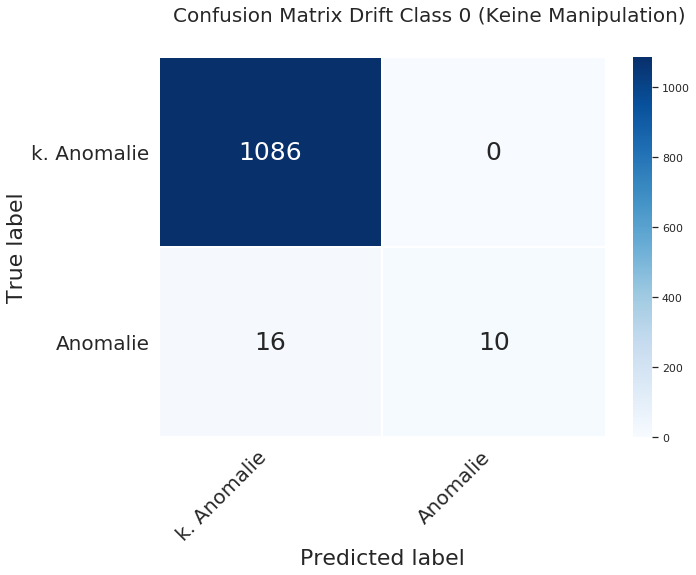

In [52]:
fig = print_confusion_matrix(cm_dc_0, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix Drift Class 0 (Keine Manipulation)', fontsize=20)
file_n = os.path.join(fig_path, 'cm_drift_class_0.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [33]:
cm_dc_1 = confusion_matrix(df_drift_class_1['reduced_ano_labels'], df_drift_class_1['ano_prediction'])
tn, fp, fn, tp  = cm_dc_1.ravel()

In [42]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 0.3512132822466436
Precision: 0.3512132822466436
Specifity: 0.0
Sensitivity: 99.9999999090909
F1-Score: 0.69996818326217


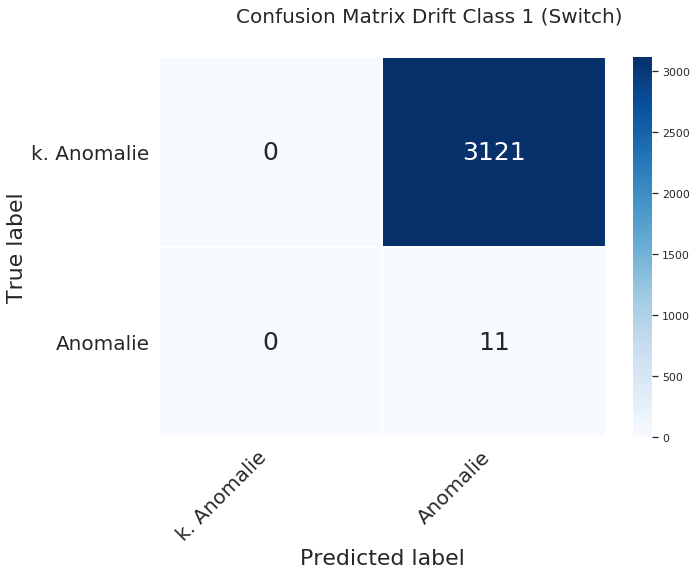

In [56]:
fig = print_confusion_matrix(cm_dc_1, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix Drift Class 1 (Switch)', fontsize=20)
file_n = os.path.join(fig_path, 'meta_modell_cm_drift_class_1.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [46]:
cm_dc_2 = confusion_matrix(df_drift_class_2['reduced_ano_labels'], df_drift_class_2['ano_prediction'])
tn, fp, fn, tp  = cm_dc_2.ravel()

In [47]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 98.74544945387916
Precision: 91.50442477835618
Specifity: 88.27065963354984
Sensitivity: 98.47619047572155
F1-Score: 94.86238532088335


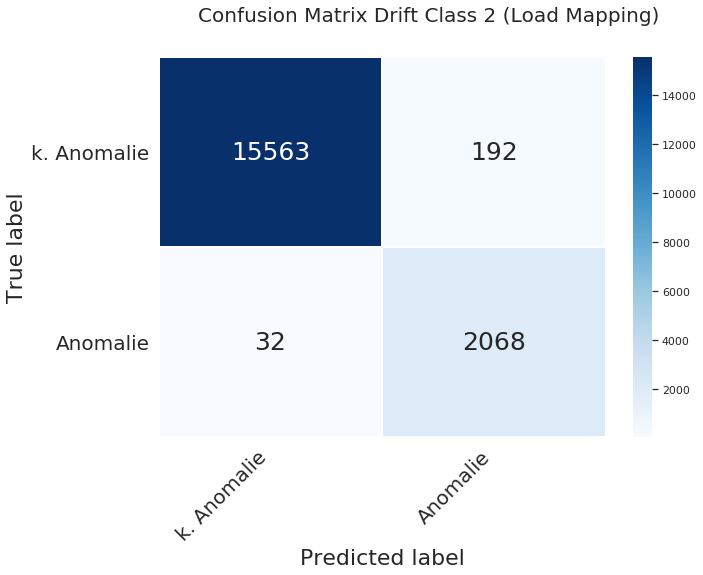

In [57]:
fig = print_confusion_matrix(cm_dc_2, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix Drift Class 2 (Load Mapping)', fontsize=20)
file_n = os.path.join(fig_path, 'meta_modell_cm_drift_class_2.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [49]:
cm_dc_3 = confusion_matrix(df_drift_class_3['reduced_ano_labels'], df_drift_class_3['ano_prediction'])
tn, fp, fn, tp  = cm_dc_3.ravel()

In [50]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 98.99544084684415
Precision: 99.99999999565216
Specifity: 98.2046678634781
Sensitivity: 63.88888888711419
F1-Score: 77.9661016935938


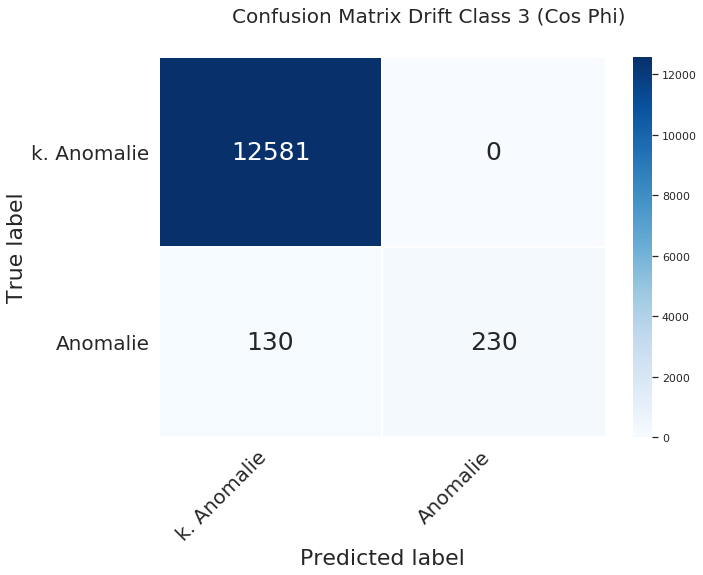

In [58]:
fig = print_confusion_matrix(cm_dc_3, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix Drift Class 3 (Cos Phi)', fontsize=20)
file_n = os.path.join(fig_path, 'meta_modell_cm_drift_class_3.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )